<a href="https://colab.research.google.com/github/vgorbikov/image_processing/blob/main/03_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Мультиклассовая классификация с использованием Pytorch

В этом задании вам предстоит решить задачу классификации используя фреймворк Pytorch. Необходимо выбрать **один из предлагаемых датасетов**:

- Распознавание жестов [[Homepage](https://www.kaggle.com/datasets/ayuraj/asl-dataset)]
- Классификация изображений медуз [[Homepage](https://www.kaggle.com/datasets/anshtanwar/jellyfish-types)]

*Ссылки на скачивание датасетов вы сможете найти на странице задания в системе Moodle*.

В папке помимо картинок вы найдете `.csv` файлы, в которых хранится информация о разбиении данных на тренировочную и валидационную части, а также метки класса, к которому изображения принадлежат.

Вам необходимо реализовать полный цикл обучения, начиная с подготовки и загрузки данных, заканчивая созданием модели сверточной нейронной сети.

**В ноутбуке вам необходимо**:
- Отобразить 2-3 картинки из датасета и подписать соответствующий ей класс
- Создать Dataloaders
- Собрать модель сверточной нейронной сети (ограничений по архитектуре нет)
- На каждой эпохе выводить значения тренировочного и валидационного **лосса**, а также **метрик** (будем использовать Accuracy и AUC-ROC; пользоваться готовыми реализациями метрик можно).
- В конце построить график зависимости лосса и метрик от номера эпохи.

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 14.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [2]:
# YOUR CODE HERE
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torchmetrics

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
dataset_path = '/content/drive/My Drive/assignments/03_classification/asl'

Mounted at /content/drive/


In [3]:
images = []
img_classes = []

imgs_classes_path = dataset_path + '/images'
for img_cls in os.listdir(imgs_classes_path):
  current_class_path = imgs_classes_path + f'/{img_cls}'
  print(f'- Load class {img_cls}')

  for img_name in os.listdir(current_class_path):
    img_path = current_class_path + f'/{img_name}'
    img = imread(img_path)

    if len(img_classes)>1:
        position = random.randint(0, len(img_classes)-1)
    else:
       position = 0

    images.insert(position, img)
    img_classes.insert(position, img_cls)


images = np.array(images)
print(images.shape)
# np.savetxt(dataset_path+'/images_asl.txt', images.flatten())

- Load class 1
- Load class 2
- Load class 5
- Load class 0
- Load class 6
- Load class 4
- Load class 3
- Load class 7
- Load class e
- Load class a
- Load class d
- Load class c
- Load class 8
- Load class f
- Load class 9
- Load class b
- Load class h
- Load class g
- Load class k
- Load class o
- Load class n
- Load class i
- Load class m
- Load class p
- Load class j
- Load class l
- Load class q
- Load class r
- Load class t
- Load class s
- Load class x
- Load class v
- Load class w
- Load class z
- Load class u
- Load class y
(2515, 400, 400, 3)


In [12]:
tmp_classet = sorted(set(img_classes))
img_classcodes = {tmp_classet[i]:np.zeros(len(tmp_classet)) for i in range(len(tmp_classet))}
for i in range(len(tmp_classet)):
  img_classcodes[tmp_classet[i]][i] = 1

img_classcodes_inv = {np.argmax(i[1]):i[0] for i in img_classcodes.items()}

img_classes_cat = np.array([img_classcodes[cls] for cls in img_classes])
print(img_classes_cat.shape)
print(img_classcodes_inv)

(2515, 36)
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'a', 11: 'b', 12: 'c', 13: 'd', 14: 'e', 15: 'f', 16: 'g', 17: 'h', 18: 'i', 19: 'j', 20: 'k', 21: 'l', 22: 'm', 23: 'n', 24: 'o', 25: 'p', 26: 'q', 27: 'r', 28: 's', 29: 't', 30: 'u', 31: 'v', 32: 'w', 33: 'x', 34: 'y', 35: 'z'}


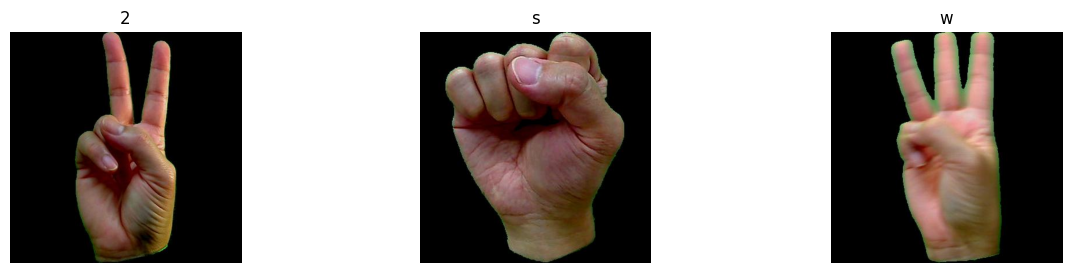

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

for i in range(3):
  img_no = random.randint(0, len(img_classes))
  axes[i].imshow(images[img_no])
  axes[i].set_title(img_classcodes_inv[np.argmax(img_classes_cat[img_no])])
  axes[i].axis('off')

fig.show()

In [14]:
class DatasetASL(Dataset):

    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform

    def __getitem__(self, index):
        """Load and return a sample from the dataset at the given index."""
        img = self.x_data[index]

        # augmentations
        if self.transform is not None:
            img = self.transform(img)

        label = torch.from_numpy(self.y_data[index])

        return img, label

    def __len__(self):
        """Return the number of samples in dataset."""
        return len(self.x_data)

In [60]:
class DatamoduleASL():
    """Create dataset and loaders, apply transforms."""

    def __init__(self):
        # load data
        (self.x_train, self.y_train), (self.x_test, self.y_test) = (np.copy(images[0:2200]), np.copy(img_classes_cat[0:2200])), (np.copy(images[2200:2515]), np.copy(img_classes_cat[2200:2515]))

        # make dataset smaller if needed
        # self.x_train = self.x_train[:1000]
        # self.y_train = self.y_train[:1000]
        # self.x_test = self.x_test[:1000]
        # self.y_test = self.y_test[:1000]

    def create_loaders(self):
        """Create loaders both for train and test/validation datasets."""

        # train dataset
        dset_train = DatasetASL(self.x_train, self.y_train, transform=transforms.ToTensor())
        # test dataset
        dset_test = DatasetASL(self.x_test, self.y_test, transform=transforms.ToTensor())

        # Train and test dataloaders
        train_loader = DataLoader(dset_train, batch_size=10, shuffle=False)
        test_loader = DataLoader(dset_test, batch_size=5, shuffle=False)

        return train_loader, test_loader

In [83]:
class ModelASL(nn.Module):

    def __init__(self):
        super().__init__()

        # CNN
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Flatten(),
            nn.Linear(in_features=50 * 50 * 16, out_features=36)
        )

        self.loss_ce = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(self.cnn.parameters(), lr=1e-3)

        # Metrics
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=36)
        self.prec = torchmetrics.Precision(task='multiclass', num_classes=36)

    def forward(self, x):
        return self.cnn(x)

    def fit(self, train_loader, test_loader, num_epoch=5):
        train_loss_stat = []
        train_acc_stat = []
        train_prec_stat = []

        for ii in range(num_epoch):

            loss_batches = []
            preds_train = []
            labels_train = []
            # train
            for step, (images, labels) in enumerate(train_loader):

                # to cuda
                images = images.cuda()
                labels = labels.type(torch.LongTensor).cuda()

                self.cnn.train()
                # make prediction
                logits_cls = self.forward(images)
                # calculate loss
                loss = self.loss_ce(logits_cls, labels[:, 0])

                # update weights
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # save loss
                loss_batches.append(loss.item())

                # predictions
                labels_pred = torch.argmax(nn.Softmax(dim=1)(logits_cls), dim=1)

                preds_train.append(labels_pred)
                labels_train.append(labels[:, 0])


            # find metrics in the end of the epoch
            predictions = torch.cat([preds for preds in preds_train])
            labels = torch.cat([labels for labels in labels_train])

            acc_train = self.accuracy(predictions, labels)
            prec_train = self.prec(predictions, labels)

            train_loss_stat.append(np.mean(loss_batches))
            train_acc_stat.append(acc_train)
            train_prec_stat.append(prec_train)

            print(f"Epoch: {ii}")
            print(f"TRAIN | Loss: {np.mean(loss_batches): .3f}, Train_acc: {acc_train: .3f}, Train_prec: {prec_train: .3f}")

            # test
            with torch.no_grad():
                loss_batches_test = []
                preds_test = []
                labels_test = []
                for step, (images, labels) in enumerate(test_loader):

                    images = images.cuda()
                    labels = labels.type(torch.LongTensor).cuda()

                    self.cnn.eval()
                    logits_cls = self.forward(images)

                    loss = self.loss_ce(logits_cls, labels[:, 0])

                    # save loss
                    loss_batches_test.append(loss.item())

                    # predictions
                    labels_pred = torch.argmax(nn.Softmax(dim=1)(logits_cls), dim=1)

                    preds_test.append(labels_pred)
                    labels_test.append(labels[:, 0])

                # find metrics in the end of the epoch
                predictions = torch.cat([preds for preds in preds_test])
                labels = torch.cat([labels for labels in labels_test])

                acc_test = self.accuracy(predictions, labels)
                prec_test = self.prec(predictions, labels)

                print(f"TEST | Loss: {np.mean(loss_batches_test): .3f}, Test_acc: {acc_test: .3f}, Test_prec: {prec_test: .3f}")
        return train_loss_stat, train_acc_stat, train_prec_stat



In [84]:
cnn_model = ModelASL().cuda()

train_loader, test_loader = DatamoduleASL().create_loaders()

losstat, accstat, precstat = cnn_model.fit(train_loader, test_loader, 5)

Epoch: 0
TRAIN | Loss:  0.109, Train_acc:  0.966, Train_prec:  0.966
TEST | Loss:  0.061, Test_acc:  0.978, Test_prec:  0.978
Epoch: 1
TRAIN | Loss:  0.054, Train_acc:  0.978, Train_prec:  0.978
TEST | Loss:  0.040, Test_acc:  0.981, Test_prec:  0.981
Epoch: 2
TRAIN | Loss:  0.028, Train_acc:  0.988, Train_prec:  0.988
TEST | Loss:  0.023, Test_acc:  0.994, Test_prec:  0.994
Epoch: 3
TRAIN | Loss:  0.016, Train_acc:  0.995, Train_prec:  0.995
TEST | Loss:  0.019, Test_acc:  0.994, Test_prec:  0.994
Epoch: 4
TRAIN | Loss:  0.005, Train_acc:  0.999, Train_prec:  0.999
TEST | Loss:  0.062, Test_acc:  0.981, Test_prec:  0.981


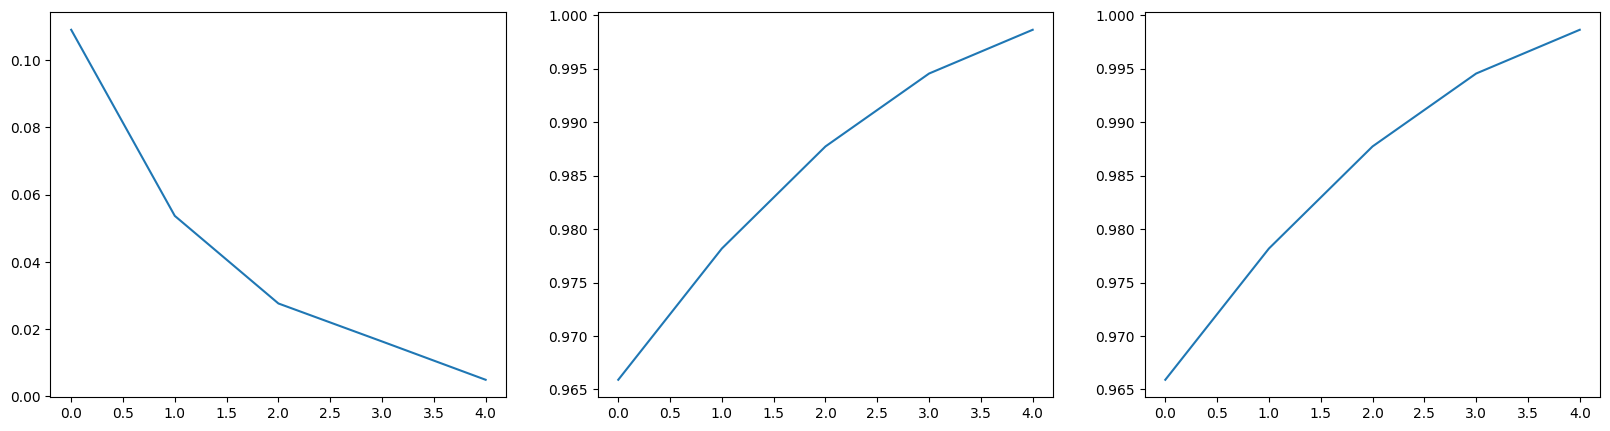

In [85]:
fig_stat, ax_stat = plt.subplots(1, 3, figsize=(20, 5))
accstat = [s.cpu() for s in accstat]
precstat = [s.cpu() for s in precstat]

ax_stat[0].plot(losstat)
ax_stat[1].plot(accstat)
ax_stat[2].plot(precstat)
fig_stat.show()

**Отлично, сеть полностью обучилась!**

Но есть *нюанс*...

(2515, 400, 400, 3)


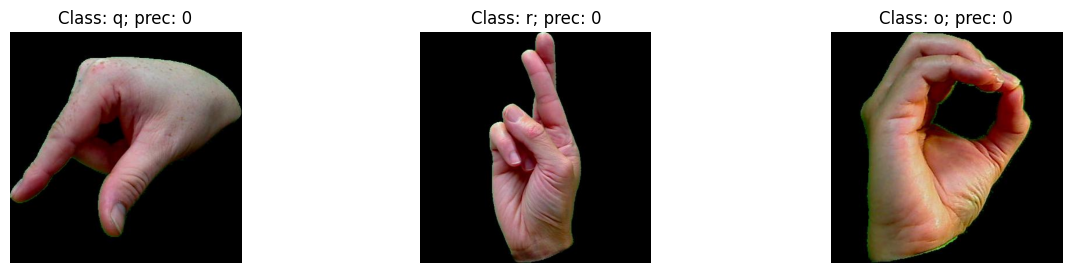

In [86]:
print(images.shape)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))


for i in range(3):
  img_no = random.randint(0, len(img_classes))
  img = torch.tensor(np.moveaxis([images[img_no]], -1, 1)).type(torch.FloatTensor).cuda()
  prec = torch.argmax(cnn_model.forward(img))
  # print(cnn_model.forward(img))
  # print(img_classes_cat[img_no])
  axes[i].imshow(images[img_no])
  axes[i].set_title(f'Class: {img_classes[img_no]}; prec: {img_classcodes_inv[int(prec)]}')
  axes[i].axis('off')

fig.show()

Отчего так происходит я так и не понял - судя по мертикам, сеть прекрасно угадывает изображения. При непосредственном выводе результата - выводит полную ерунду. Она просто всегда предсказывает ноль...

## **Перед отправкой сохраните ноутбук с именем в следующем формате: 03_Фамилия.ipynb**